In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.8.2 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.8.2 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.8.2 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.8.2 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.26.0 which is incompatible.


In [2]:
!pip install -q tf-models-official==2.7.0

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
import re
from collections import Counter
import random

import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
TRAIN_FP = '../input/nlp-getting-started/train.csv'
TEST_FP = '../input/nlp-getting-started/test.csv'

train = pd.read_csv(TRAIN_FP)
test = pd.read_csv(TEST_FP)

In [5]:
disaster_tweets = train.loc[train['target'] == 1, :].shape[0]
total_tweets = train.shape[0]
print(f'{disaster_tweets} disasters, {(disaster_tweets/total_tweets)*100:.2f}% of training set')

3271 disasters, 42.97% of training set


In [6]:
train_duplicates = train.loc[train.duplicated(subset='text', keep=False), :]
num_unique_duplicated_tweets = train_duplicates.loc(axis=1)['text'].unique().shape[0]
num_total_duplicated_tweets = train_duplicates.shape[0]

print(f'{num_unique_duplicated_tweets} tweets duplicated, {num_total_duplicated_tweets} total duplicates')

69 tweets duplicated, 179 total duplicates


In [7]:
# For the duplicated entries, if not marked the same => drop altogether
duplicated_tweets = train_duplicates.loc(axis=1)['text'].unique()
train_first_of_duplicate = pd.DataFrame(columns=train.columns)

for tweet in duplicated_tweets:
    if train_duplicates.loc(axis=0)[train_duplicates['text'] == tweet]['target'].unique().shape[0] == 1:
        train_first_of_duplicate = pd.concat([
            train_first_of_duplicate,
            pd.DataFrame(train_duplicates.loc(axis=0)[train_duplicates['text'] == tweet].iloc[0]).T
        ],
            ignore_index=True
        )

# All of training set with none of the duplicates
train_unduplicated = train.drop_duplicates(subset='text', keep=False)

# All of training set with first instance of each duplicate included
train_all_no_duplicates = pd.concat([
    train_first_of_duplicate,
    train_unduplicated     
],
    ignore_index=True
)

# Check no duplicates remain
remaining_duplicates = train_all_no_duplicates.loc[train_all_no_duplicates.duplicated(subset='text', keep=False), :]
print(f'Remaining duplicates in training set: {remaining_duplicates.shape[0]}')

Remaining duplicates in training set: 0


In [8]:
train_set = train_all_no_duplicates
test_set = test

### BERT Import

In [9]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
example_num = random.randint(0, train_set.shape[0])
text_test = [train_set['text'].iloc[example_num]]
print(text_test)
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

['Illinois Tornado Slipped Under The Radar Emergency Officials Say http://t.co/P4KOfYtkdx']
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  4307 11352  5707  2104  1996  7217  5057  4584  2360  8299  1024]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.8844844   0.9967306   0.24577737  0.2052948   0.41838053  0.624643
  0.98742205 -0.996818   -0.3656802  -0.8112729   0.02072321 -0.29745165]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.58391833 -0.26815656  0.6468274  ... -0.5526948   0.669403
   0.7051046 ]
 [-1.1556492  -0.58805084  0.5148251  ... -0.6957811  -0.65898854
   0.30932945]
 [-1.4050707  -0.63141024  1.1090816  ... -0.11508945 -0.195117
   1.0922925 ]
 ...
 [-0.06617551 -1.0483196   0.7008393  ... -0.6694847   0.804911
   0.7448319 ]
 [ 0.85901976  0.50396395  0.7900193  ... -0.38401812  0.37821126
  -0.66779166]
 [ 0.12199186 -0.34872767  0.5538878  ...  0.38463527 -0.8972739
  -1.7408229 ]]


In [13]:
def build_classifier_model():
    input_word_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_word_ids")
    input_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_type_ids")
    input_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_mask")
    
    encoder_inputs = {
        "input_word_ids": input_word_ids,
        "input_type_ids": input_type_ids,
        "input_mask": input_mask
    }
    
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
#     net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(inputs=[input_word_ids, input_type_ids, input_mask], outputs=net)
    

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model([
    text_preprocessed["input_word_ids"],
    text_preprocessed["input_type_ids"],
    text_preprocessed["input_mask"],
])
print(bert_raw_result)

tf.Tensor([[0.4147902]], shape=(1, 1), dtype=float32)


### Pre-Processing

In [15]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "ig" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [16]:
# Clean up tweet content

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def convert_abbrev(word):
    return abbreviations[word] if word in abbreviations.keys() else word

def preprocess_text(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()          
    sentence = sentence.replace('{html}', "") 
    rem_url = re.sub(r'http\S+', '', sentence)
    converted_abbrev = " ".join([convert_abbrev(word) for word in rem_url.split(" ")])
    cleanr = re.compile('[^a-z ]+')
    rem_num_non_alpha = re.sub(cleanr, '', converted_abbrev)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num_non_alpha)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
#     stem_words = [stemmer.stem(w) for w in filtered_words]
#     lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

train_set['clean_text'] = train_set['text'].map(lambda s:preprocess_text(s))
train_set.head()

,id,keyword,location,text,target,clean_text
0,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,check nsfw
1,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,icemoon aftershock djicemoon dubstep trapmusic...
2,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,icemoon aftershock djicemoon dubstep trapmusic...
3,211,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1,experts france begin examining airplane debris...
4,1634,bombing,NaN,Japan on Thursday marks the 70th anniversary o...,1,japan thursday marks anniversary atomic bombin...


In [17]:
X = train_set.loc(axis=1)['clean_text'].to_numpy()
y = train_set.loc(axis=1)['target'].to_numpy().astype('float32')

random.seed(42)
train_indices = random.sample(range(len(y)), 6720)
valid_indices = []
for i in range(len(y)):
    if i not in train_indices:
        valid_indices.append(i)

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[valid_indices], y[valid_indices]

print(f'Training Set X: {X_train.shape}, y: {y_train.shape}')
print(f'Validation Set X: {X_val.shape}, y: {y_val.shape}')

Training Set X: (6720,), y: (6720,)
Validation Set X: (765,), y: (765,)


In [18]:
def create_input(text):
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    text_preprocessed = bert_preprocess_model(text)
    return text_preprocessed["input_word_ids"], text_preprocessed["input_type_ids"], text_preprocessed["input_mask"]

In [19]:
from tqdm import tqdm_notebook as tqdm

train_word_ids = np.empty((0,128)).astype('float32')
train_type_ids = np.empty((0,128)).astype('float32')
train_mask = np.empty((0,128)).astype('float32')

batch = 160
num_steps = len(X_train) // batch

for i in tqdm(range(num_steps)):
    word_id, type_id, mask = create_input(X_train[i*batch:(i+1)*batch])
    train_word_ids = np.append(train_word_ids, word_id, axis=0)
    train_type_ids = np.append(train_type_ids, type_id, axis=0)
    train_mask = np.append(train_mask, mask, axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/42 [00:00<?, ?it/s]

In [20]:
# %%time
# train_word_ids, train_type_ids, train_mask = create_input(X_train)

In [21]:
print('Shape of train_word_ids:', train_word_ids.shape)
print('Shape of train_type_ids:', train_type_ids.shape)
print('Shape of train_mask:', train_mask.shape)

Shape of train_word_ids: (6720, 128)
Shape of train_type_ids: (6720, 128)
Shape of train_mask: (6720, 128)


In [22]:
%%time
val_word_ids, val_type_ids, val_mask = create_input(X_val)

CPU times: user 28.5 s, sys: 5.97 s, total: 34.4 s
Wall time: 19.8 s


In [23]:
print('Shape of valid_word_ids:', val_word_ids.shape)
print('Shape of valid_type_ids:', val_type_ids.shape)
print('Shape of valid_mask:', val_mask.shape)

Shape of valid_word_ids: (765, 128)
Shape of valid_type_ids: (765, 128)
Shape of valid_mask: (765, 128)


In [24]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [25]:
NUM_EPOCHS = 6
BATCH_SIZE = 160
STEPS_PER_EPOCH = len(y_train) // BATCH_SIZE
print(f'{STEPS_PER_EPOCH} steps per epoch')

NUM_TRAIN_STEPS = STEPS_PER_EPOCH * NUM_EPOCHS
NUM_WARMUP_STEPS = int(0.1*NUM_TRAIN_STEPS)
print(f'{NUM_TRAIN_STEPS} training steps')

42 steps per epoch
252 training steps


In [26]:
init_lr = 5e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=NUM_TRAIN_STEPS,
                                          num_warmup_steps=NUM_WARMUP_STEPS,
                                          optimizer_type='adamw')


In [27]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
callback = [early_stopping]

In [29]:
history = classifier_model.fit(
    [train_word_ids, train_type_ids, train_mask], y_train, 
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=([val_word_ids, val_type_ids, val_mask], y_val),
    callbacks=callback
)

Epoch 1/6
42/42 [==============================] - 26s 472ms/step - loss: 0.5464 - binary_accuracy: 0.7143 - val_loss: 0.4257 - val_binary_accuracy: 0.8078
Epoch 2/6
42/42 [==============================] - 19s 457ms/step - loss: 0.4068 - binary_accuracy: 0.8307 - val_loss: 0.4365 - val_binary_accuracy: 0.8013
Epoch 3/6
42/42 [==============================] - 19s 459ms/step - loss: 0.3561 - binary_accuracy: 0.8515 - val_loss: 0.4157 - val_binary_accuracy: 0.8288
Epoch 4/6
42/42 [==============================] - 19s 457ms/step - loss: 0.3154 - binary_accuracy: 0.8716 - val_loss: 0.4714 - val_binary_accuracy: 0.7843
Epoch 5/6
42/42 [==============================] - 19s 457ms/step - loss: 0.2837 - binary_accuracy: 0.8875 - val_loss: 0.4662 - val_binary_accuracy: 0.7974
Epoch 6/6
42/42 [==============================] - 19s 458ms/step - loss: 0.2674 - binary_accuracy: 0.8960 - val_loss: 0.4763 - val_binary_accuracy: 0.7948


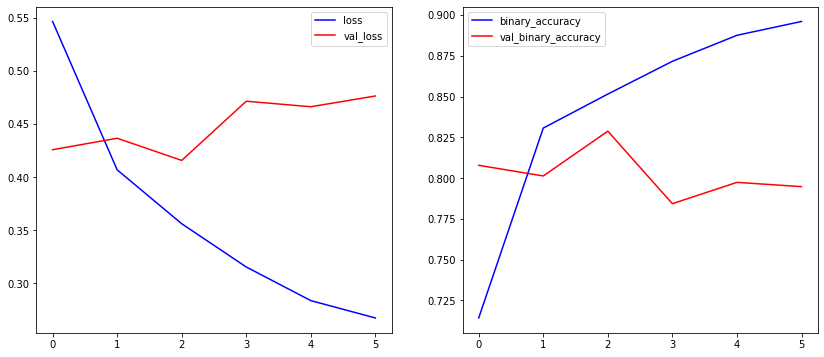

In [30]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
axs[0].plot(history.history['loss'], color='blue')
axs[0].plot(history.history['val_loss'], color='red')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(history.history['binary_accuracy'], color='blue')
axs[1].plot(history.history['val_binary_accuracy'], color='red')
axs[1].legend(['binary_accuracy', 'val_binary_accuracy'])

### Test Model

In [31]:
test_set['clean_text'] = test_set['text'].map(lambda s:preprocess_text(s))
X_test = test_set.loc(axis=1)['clean_text'].to_numpy()
test_ids = test.loc(axis=1)['id']

In [32]:
y_test_pred = pd.DataFrame(data=test_ids, columns=['id'])
y_test_pred['target'] = np.round(classifier_model.predict(create_input(X_test))).astype('int')
y_test_pred.to_csv('./submission.csv', index=False)
y_test_pred.tail()

,id,target
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
3262,10875,1
